In [6]:
import numpy as np

from DORR_matrix import build_pauli_sum_A_strings, pauli_string_to_matrix, build_matrix_from_paulis

import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep

from device_var_lse_solver import DeviceVarLSESolver
from device import Device
from device import DeviceType
from qiskit_aer import AerSimulator

import numpy as np

from non_dynamical_ansatz import fixed_layered_ansatz
from tqdm import tqdm


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

depth = 10

# As defined by [10]
def TRC_ADA(iteration_count : dict):
    trc = 0
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += d*z
    return trc

def TRC_ASA(iteration_count : dict):
    trc = 0
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += z*depth
    return trc

In [7]:
for KAPPA in [1.01,10,400]:
    pauli_strings, coeffs, b_state = build_pauli_sum_A_strings(qubits=3, J = 0.1, kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)

    cond = np.linalg.cond(A_mat)
    print(f"alpha = {KAPPA:.4e} -> condition number = {cond:.4e}")

b = np.ones(2**3)
b = b / np.linalg.norm(b)

alpha = 1.0100e+00 -> condition number = 1.0100e+00
alpha = 1.0000e+01 -> condition number = 1.0000e+01
alpha = 4.0000e+02 -> condition number = 4.0000e+02


In [ ]:
qubits = 3
n = 2 ** qubits
kappa_list = [20, 30, 40, 70, 100]


#device = Device(DeviceType.QISKIT_AER, qubits=qubits)
device_noise = Device(DeviceType.QISKIT_AER, qubits=qubits)

save = True
redo_calc = 10

# kappa_list = [1.04e+00,1.49e+00, 10, 50, 1.58e+02]
# lr = 0.05
# threshold = 0.0001
# steps = 5000
# epochs = 10
# abort = 200


lr = 0.01
threshold = 0.0001
steps = 5000
epochs = 10
abort = 200

results_list_dynamic = np.zeros([redo_calc, n])
results_list_static = np.zeros([redo_calc, n])
results_list_dynamic_noise = np.zeros([redo_calc, n])
results_list_static_noise = np.zeros([redo_calc, n])

TRC_list_dynamic = np.zeros(redo_calc)
TRC_list_static = np.zeros(redo_calc)
TRC_list_dynamic_noise = np.zeros(redo_calc)
TRC_list_static_noise = np.zeros(redo_calc)



depth = 10
param_shape = (qubits + depth*(qubits+qubits -2),)

for KAPPA in kappa_list:
    for i in range(redo_calc):
        print(f"Run nr. {i+1}/{redo_calc}")
        A, coeffs, b = build_pauli_sum_A_strings(qubits=qubits, J=0.1, kappa=KAPPA)

        ###################################
        #####    DYNAMIC NOISELESS    #####
        ###################################

        lse_dyn_dynamic = DeviceVarLSESolver(A, 
                    b, 
                    coeffs=coeffs,
                    method="hadamard", 
                    local=True, 
                    lr=lr, 
                    threshold=threshold,
                    steps=steps,
                    epochs=epochs, 
                    abort=abort,) 

        solution_local, param_local, it_count_local = lse_dyn_dynamic.solve()
        local_dense_trc = TRC_ADA(it_count_local)
        results_list_dynamic[i, :] = solution_local
        TRC_list_dynamic[i] = local_dense_trc


          
        ###################################
        #####    STATIC  NOISELESS    #####
        ###################################

        lse_stat_static = DeviceVarLSESolver(A,
                    b, 
                    coeffs=coeffs,
                    method='hadamard',
                    ansatz=fixed_layered_ansatz,
                    weights=param_shape,
                    local=True, 
                    lr=lr, 
                    steps=steps,
                    threshold=threshold, 
                    epochs=epochs,
                    abort=abort,)
            

        solution_local, param_local, it_count_local = lse_stat_static.solve()
        results_list_static[i, :] = solution_local
        TRC_list_static[i] = TRC_ASA(it_count_local)


        ###################################
        #####    DYNAMIC NOISE    #####
        ###################################
        lse_dyn_dynamic_noise = DeviceVarLSESolver(A, 
                    b, 
                    coeffs=coeffs,
                    method="hadamard", 
                    local=True, 
                    lr=lr, 
                    threshold=threshold,
                    steps=steps,
                    epochs=epochs, 
                    device=device_noise, 
                    abort=abort,)
        solution_local, param_local, it_count_local = lse_dyn_dynamic_noise.solve()
        local_dense_trc = TRC_ADA(it_count_local)
        results_list_dynamic_noise[i, :] = solution_local
        TRC_list_dynamic_noise[i] = local_dense_trc

        ###################################
        #####    STATIC  NOISE    #####
        ###################################
        lse_stat_static_noise = DeviceVarLSESolver(A,
                    b, 
                    coeffs=coeffs,
                    method='hadamard',
                    ansatz=fixed_layered_ansatz,
                    weights=param_shape,
                    local=True, 
                    lr=lr, 
                    steps=steps,
                    threshold=threshold, 
                    epochs=epochs,
                    device=device_noise,
                    abort=abort,)
        solution_local, param_local, it_count_local = lse_stat_static_noise.solve()
        results_list_static_noise[i, :] = solution_local
        TRC_list_static_noise[i] = TRC_ASA(it_count_local)


        


    if save == True:
        filename = f"data/condition_nr/result_local_condnr_{KAPPA}_w_noise.npz"
        save_dict = {
            'A': A,
            'coeffs': coeffs,
            'b': b,
            'results_list_dynamic': results_list_dynamic,
            'TRC_list_dynamic': TRC_list_dynamic,
            'results_list_static': results_list_static,
            'TRC_list_static': TRC_list_static,
            'results_list_dynamic_noise': results_list_dynamic_noise,
            'TRC_list_dynamic_noise': TRC_list_dynamic_noise,
            'results_list_static_noise': results_list_static_noise,
            'TRC_list_static_noise': TRC_list_static_noise,
            'nr_runs': redo_calc,
            'KAPPA': KAPPA,
            'qubits': qubits,

        }
        np.savez(filename, **save_dict)
        print(f"Saved {filename}")


Run nr. 1/10
Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1/10:  12%|█▏        | 618/5000 [01:31<10:45,  6.79it/s, best loss=0.000343, last improvement in step=418, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 395/5000 [00:58<11:20,  6.77it/s, best loss=0.00308, last improvement in step=195, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  18%|█▊        | 925/5000 [02:18<10:11,  6.66it/s, best loss=0.00011, last improvement in step=873, loss=0.0001]   
Loss of 0.0000999618 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▋         | 319/5000 [00:52<12:46,  6.11it/s, best loss=0.000168, last improvement in step=119, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  18%|█▊        | 894/5000 [02:10<09:57,  6.87it/s, best loss=0.000334, last improvement in step=694, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   9%|▉         | 439/5000 [01:06<11:28,  6.63it/s, best loss=0.00308, last improvement in step=239, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   2%|▏         | 89/5000 [00:13<12:45,  6.41it/s, best loss=0.000102, last improvement in step=88, loss=0.000102]
Loss of 0.0000998580 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 297/5000 [00:49<13:01,  6.02it/s, best loss=0.000168, last improvement in step=97, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:  12%|█▏        | 579/5000 [01:25<10:50,  6.79it/s, best loss=0.000335, last improvement in step=379, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  42%|████▏     | 2092/5000 [05:16<07:20,  6.60it/s, best loss=0.00279, last improvement in step=1892, loss=0.00279]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  16%|█▋        | 822/5000 [02:05<10:38,  6.54it/s, best loss=0.000108, last improvement in step=802, loss=0.0001]  
Loss of 0.0000999234 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 251/5000 [00:41<13:13,  5.99it/s, best loss=0.000171, last improvement in step=51, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  11%|█         | 547/5000 [01:19<10:48,  6.87it/s, best loss=0.000337, last improvement in step=347, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  32%|███▏      | 1578/5000 [03:55<08:31,  6.69it/s, best loss=0.00279, last improvement in step=1378, loss=0.00279]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  18%|█▊        | 885/5000 [02:16<10:32,  6.50it/s, best loss=0.0001, last improvement in step=884, loss=0.0001]    
Loss of 0.0000998452 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 293/5000 [00:49<13:14,  5.92it/s, best loss=0.000175, last improvement in step=93, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:  15%|█▌        | 750/5000 [01:51<10:29,  6.75it/s, best loss=0.000338, last improvement in step=550, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  28%|██▊       | 1382/5000 [03:26<09:00,  6.69it/s, best loss=0.00279, last improvement in step=1182, loss=0.00278]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  32%|███▎      | 1625/5000 [04:07<08:33,  6.57it/s, best loss=0.000208, last improvement in step=1425, loss=0.0002]  
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 4/10:  16%|█▌        | 806/5000 [02:07<11:01,  6.34it/s, best loss=0.000101, last improvement in step=803, loss=0.0001]  
Loss of 0.0000994705 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 292/5000 [00:49<13:10,  5.96it/s, best loss=0.000177, last improvement in step=92, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  11%|█         | 544/5000 [01:19<10:49,  6.86it/s, best loss=0.000337, last improvement in step=344, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  17%|█▋        | 831/5000 [02:05<10:28,  6.63it/s, best loss=0.00308, last improvement in step=631, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  17%|█▋        | 864/5000 [02:11<10:30,  6.56it/s, best loss=0.000107, last improvement in step=811, loss=0.0001]  
Loss of 0.0000998675 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 307/5000 [00:51<13:04,  5.98it/s, best loss=0.000169, last improvement in step=107, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:  11%|█         | 554/5000 [01:21<10:57,  6.76it/s, best loss=0.000341, last improvement in step=354, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  12%|█▏        | 586/5000 [01:29<11:12,  6.57it/s, best loss=0.00307, last improvement in step=386, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  12%|█▏        | 610/5000 [01:33<11:10,  6.55it/s, best loss=0.000101, last improvement in step=603, loss=0.0001]  
Loss of 0.0000998464 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 299/5000 [00:49<12:54,  6.07it/s, best loss=0.000171, last improvement in step=99, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  15%|█▍        | 733/5000 [01:47<10:27,  6.80it/s, best loss=0.00034, last improvement in step=533, loss=0.000334] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  40%|███▉      | 1982/5000 [04:56<07:31,  6.68it/s, best loss=0.00279, last improvement in step=1782, loss=0.00279]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  27%|██▋       | 1333/5000 [03:24<09:23,  6.50it/s, best loss=0.000103, last improvement in step=1326, loss=0.0001]  
Loss of 0.0000998225 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 296/5000 [00:49<13:06,  5.98it/s, best loss=0.000172, last improvement in step=96, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:  16%|█▌        | 787/5000 [01:58<10:32,  6.67it/s, best loss=0.000342, last improvement in step=587, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 389/5000 [00:58<11:33,  6.65it/s, best loss=0.00307, last improvement in step=189, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  12%|█▏        | 598/5000 [01:33<11:25,  6.43it/s, best loss=0.000101, last improvement in step=593, loss=0.0001]  
Loss of 0.0000999409 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▋         | 322/5000 [00:53<13:00,  6.00it/s, best loss=0.000168, last improvement in step=122, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  15%|█▌        | 771/5000 [01:54<10:28,  6.73it/s, best loss=0.000337, last improvement in step=571, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  29%|██▉       | 1473/5000 [03:41<08:51,  6.64it/s, best loss=0.00279, last improvement in step=1273, loss=0.00279]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  15%|█▍        | 730/5000 [01:52<10:59,  6.47it/s, best loss=0.000108, last improvement in step=715, loss=0.0001]  
Loss of 0.0000997500 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 256/5000 [00:42<13:05,  6.04it/s, best loss=0.000173, last improvement in step=56, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:  14%|█▍        | 708/5000 [01:44<10:35,  6.75it/s, best loss=0.000343, last improvement in step=508, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 377/5000 [00:58<11:55,  6.46it/s, best loss=0.00307, last improvement in step=177, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▌         | 307/5000 [00:47<12:10,  6.42it/s, best loss=0.000107, last improvement in step=281, loss=0.0001]  
Loss of 0.0000997259 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 284/5000 [00:49<13:38,  5.76it/s, best loss=0.000176, last improvement in step=84, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  10%|█         | 523/5000 [01:17<11:04,  6.74it/s, best loss=0.000343, last improvement in step=323, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 344/5000 [00:53<11:58,  6.48it/s, best loss=0.00307, last improvement in step=144, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  18%|█▊        | 879/5000 [02:15<10:36,  6.47it/s, best loss=0.000105, last improvement in step=857, loss=0.0001]  
Loss of 0.0000998640 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 285/5000 [00:47<13:14,  5.94it/s, best loss=0.000174, last improvement in step=85, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:  14%|█▎        | 675/5000 [01:39<10:40,  6.76it/s, best loss=0.00034, last improvement in step=475, loss=0.000334] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  14%|█▍        | 716/5000 [01:48<10:48,  6.60it/s, best loss=0.00308, last improvement in step=516, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  12%|█▏        | 616/5000 [01:35<11:19,  6.45it/s, best loss=0.0001, last improvement in step=615, loss=0.0001]    
Loss of 0.0000985984 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 305/5000 [00:51<13:14,  5.91it/s, best loss=0.00017, last improvement in step=105, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  11%|█         | 534/5000 [01:19<11:03,  6.74it/s, best loss=0.000336, last improvement in step=334, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 334/5000 [00:50<11:44,  6.62it/s, best loss=0.00308, last improvement in step=134, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  12%|█▏        | 619/5000 [01:36<11:20,  6.44it/s, best loss=0.000102, last improvement in step=615, loss=0.0001]  
Loss of 0.0000998831 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 285/5000 [00:48<13:21,  5.88it/s, best loss=0.000172, last improvement in step=85, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:  11%|█         | 544/5000 [01:20<10:57,  6.78it/s, best loss=0.000339, last improvement in step=344, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 385/5000 [00:57<11:23,  6.75it/s, best loss=0.00308, last improvement in step=185, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  17%|█▋        | 842/5000 [02:05<10:21,  6.69it/s, best loss=0.000108, last improvement in step=817, loss=0.0001]  
Loss of 0.0000997634 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 305/5000 [00:49<12:48,  6.11it/s, best loss=0.00017, last improvement in step=105, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  15%|█▌        | 759/5000 [01:49<10:14,  6.90it/s, best loss=0.000338, last improvement in step=559, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 338/5000 [00:49<11:24,  6.81it/s, best loss=0.00308, last improvement in step=138, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  23%|██▎       | 1132/5000 [02:50<09:41,  6.65it/s, best loss=0.000105, last improvement in step=1121, loss=0.0001]  
Loss of 0.0000999393 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 251/5000 [00:41<12:57,  6.11it/s, best loss=0.000171, last improvement in step=51, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:  14%|█▎        | 675/5000 [01:38<10:30,  6.86it/s, best loss=0.000337, last improvement in step=475, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  21%|██        | 1059/5000 [02:35<09:36,  6.83it/s, best loss=0.0025, last improvement in step=859, loss=0.0025] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  10%|█         | 510/5000 [01:16<11:12,  6.68it/s, best loss=0.000107, last improvement in step=488, loss=0.0001]  
Loss of 0.0000997227 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 311/5000 [00:50<12:46,  6.12it/s, best loss=0.000172, last improvement in step=111, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  14%|█▎        | 682/5000 [01:37<10:19,  6.98it/s, best loss=0.000334, last improvement in step=482, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  14%|█▍        | 709/5000 [01:43<10:28,  6.83it/s, best loss=0.00307, last improvement in step=509, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   7%|▋         | 370/5000 [00:55<11:36,  6.65it/s, best loss=0.000107, last improvement in step=356, loss=0.0001]  
Loss of 0.0000996431 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 296/5000 [00:48<12:50,  6.11it/s, best loss=0.000177, last improvement in step=96, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:  15%|█▌        | 757/5000 [01:48<10:10,  6.95it/s, best loss=0.000336, last improvement in step=557, loss=0.000334]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  25%|██▌       | 1269/5000 [03:07<09:09,  6.79it/s, best loss=0.00279, last improvement in step=1069, loss=0.00278]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  12%|█▏        | 614/5000 [01:32<11:03,  6.61it/s, best loss=0.00011, last improvement in step=592, loss=0.0001]   
Loss of 0.0000998910 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 293/5000 [00:48<12:58,  6.04it/s, best loss=0.00017, last improvement in step=93, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  15%|█▍        | 731/5000 [01:45<10:15,  6.93it/s, best loss=0.00034, last improvement in step=531, loss=0.000334] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 355/5000 [00:52<11:23,  6.79it/s, best loss=0.00308, last improvement in step=155, loss=0.00307]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  33%|███▎      | 1656/5000 [04:07<08:20,  6.68it/s, best loss=0.000108, last improvement in step=1597, loss=0.0001]  
Loss of 0.0000999990 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 291/5000 [00:47<12:49,  6.12it/s, best loss=0.000175, last improvement in step=91, loss=0.000167]
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_20_w_noise.npz
Run nr. 1/10
Epoch 1/10:  16%|█▌        | 781/5000 [01:52<10:09,  6.92it/s, best loss=0.000351, last improvement in step=581, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  10%|▉         | 495/5000 [01:12<11:02,  6.80it/s, best loss=0.00168, last improvement in step=295, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   8%|▊         | 405/5000 [01:01<11:35,  6.61it/s, best loss=0.000108, last improvement in step=355, loss=0.0001]  
Loss of 0.0000999811 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 295/5000 [00:48<12:54,  6.08it/s, best loss=0.000178, last improvement in step=95, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  13%|█▎        | 669/5000 [01:36<10:24,  6.93it/s, best loss=0.000353, last improvement in step=469, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  37%|███▋      | 1855/5000 [04:34<07:45,  6.76it/s, best loss=0.00141, last improvement in step=1655, loss=0.0014] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  24%|██▍       | 1222/5000 [03:03<09:27,  6.66it/s, best loss=0.000214, last improvement in step=1022, loss=0.000205]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 4/10:  28%|██▊       | 1399/5000 [03:33<09:09,  6.55it/s, best loss=0.000105, last improvement in step=1385, loss=0.0001]  
Loss of 0.0000997259 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 283/5000 [00:46<12:49,  6.13it/s, best loss=0.000183, last improvement in step=83, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:  11%|█         | 534/5000 [01:16<10:38,  6.99it/s, best loss=0.000351, last improvement in step=334, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  12%|█▏        | 611/5000 [01:29<10:40,  6.86it/s, best loss=0.00169, last improvement in step=411, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  21%|██▏       | 1074/5000 [02:40<09:45,  6.70it/s, best loss=0.000109, last improvement in step=1018, loss=0.0001]  
Loss of 0.0000999938 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 285/5000 [00:46<12:56,  6.07it/s, best loss=0.000178, last improvement in step=85, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   9%|▉         | 461/5000 [01:09<11:19,  6.68it/s, best loss=0.000346, last improvement in step=261, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  25%|██▌       | 1259/5000 [03:03<09:05,  6.86it/s, best loss=0.00112, last improvement in step=1059, loss=0.00112]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▌         | 278/5000 [00:41<11:47,  6.67it/s, best loss=0.000101, last improvement in step=277, loss=0.000101]
Loss of 0.0000996567 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 308/5000 [00:50<12:45,  6.13it/s, best loss=0.000176, last improvement in step=108, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:  13%|█▎        | 627/5000 [01:30<10:28,  6.95it/s, best loss=0.000355, last improvement in step=427, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  43%|████▎     | 2137/5000 [05:13<07:00,  6.81it/s, best loss=0.00113, last improvement in step=1937, loss=0.00112]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   8%|▊         | 423/5000 [01:03<11:28,  6.65it/s, best loss=0.000106, last improvement in step=408, loss=0.0001]  
Loss of 0.0000999592 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 284/5000 [00:46<12:48,  6.14it/s, best loss=0.000181, last improvement in step=84, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  12%|█▏        | 602/5000 [01:27<10:38,  6.89it/s, best loss=0.000354, last improvement in step=402, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 346/5000 [00:50<11:25,  6.79it/s, best loss=0.00169, last improvement in step=146, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   7%|▋         | 350/5000 [00:52<11:37,  6.67it/s, best loss=0.000335, last improvement in step=150, loss=0.000331]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 4/10:  26%|██▋       | 1317/5000 [03:21<09:23,  6.54it/s, best loss=0.000102, last improvement in step=1311, loss=0.0001]  
Loss of 0.0000995705 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 285/5000 [00:46<12:57,  6.07it/s, best loss=0.000181, last improvement in step=85, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:  13%|█▎        | 633/5000 [01:32<10:35,  6.87it/s, best loss=0.000354, last improvement in step=433, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  22%|██▏       | 1076/5000 [02:37<09:33,  6.84it/s, best loss=0.00112, last improvement in step=876, loss=0.00111]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▍         | 223/5000 [00:34<12:20,  6.45it/s, best loss=0.000103, last improvement in step=221, loss=0.000101]
Loss of 0.0000999404 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 300/5000 [00:48<12:46,  6.13it/s, best loss=0.000182, last improvement in step=100, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  12%|█▏        | 588/5000 [01:25<10:41,  6.88it/s, best loss=0.000345, last improvement in step=388, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 366/5000 [00:53<11:21,  6.80it/s, best loss=0.00168, last improvement in step=166, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  16%|█▋        | 824/5000 [02:03<10:26,  6.67it/s, best loss=0.00018, last improvement in step=624, loss=0.000173]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 4/10:  21%|██        | 1030/5000 [02:37<10:05,  6.56it/s, best loss=0.000106, last improvement in step=1017, loss=0.0001]  
Loss of 0.0000998656 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 292/5000 [00:49<13:11,  5.95it/s, best loss=0.00018, last improvement in step=92, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:  13%|█▎        | 631/5000 [01:32<10:37,  6.86it/s, best loss=0.000354, last improvement in step=431, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  10%|▉         | 498/5000 [01:18<11:50,  6.34it/s, best loss=0.00169, last improvement in step=298, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  25%|██▌       | 1259/5000 [03:09<09:23,  6.64it/s, best loss=0.000108, last improvement in step=1235, loss=0.0001]  
Loss of 0.0000996760 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 279/5000 [00:45<12:48,  6.14it/s, best loss=0.000183, last improvement in step=79, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  15%|█▍        | 746/5000 [01:48<10:16,  6.90it/s, best loss=0.000354, last improvement in step=546, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 425/5000 [01:03<11:27,  6.65it/s, best loss=0.00169, last improvement in step=225, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  16%|█▌        | 806/5000 [02:01<10:34,  6.61it/s, best loss=0.000103, last improvement in step=796, loss=0.0001]  
Loss of 0.0000998471 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 284/5000 [00:47<13:08,  5.98it/s, best loss=0.000174, last improvement in step=84, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:  12%|█▏        | 611/5000 [01:31<10:53,  6.71it/s, best loss=0.000354, last improvement in step=411, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   9%|▉         | 440/5000 [01:08<11:52,  6.40it/s, best loss=0.00169, last improvement in step=240, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  16%|█▌        | 793/5000 [02:16<12:02,  5.82it/s, best loss=0.000103, last improvement in step=774, loss=0.0001]  
Loss of 0.0000999385 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 289/5000 [00:46<12:43,  6.17it/s, best loss=0.000175, last improvement in step=89, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  11%|█         | 552/5000 [01:19<10:37,  6.98it/s, best loss=0.000353, last improvement in step=352, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  10%|▉         | 498/5000 [01:12<10:57,  6.85it/s, best loss=0.00168, last improvement in step=298, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  33%|███▎      | 1632/5000 [04:03<08:21,  6.71it/s, best loss=0.0001, last improvement in step=1628, loss=0.0001]    
Loss of 0.0000998677 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 287/5000 [00:46<12:44,  6.16it/s, best loss=0.000178, last improvement in step=87, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:  14%|█▎        | 684/5000 [01:37<10:17,  6.98it/s, best loss=0.000349, last improvement in step=484, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  37%|███▋      | 1847/5000 [04:30<07:41,  6.84it/s, best loss=0.0014, last improvement in step=1647, loss=0.00139] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  26%|██▋       | 1315/5000 [03:16<09:11,  6.68it/s, best loss=0.000104, last improvement in step=1294, loss=0.0001]  
Loss of 0.0000999968 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 287/5000 [00:46<12:42,  6.18it/s, best loss=0.000176, last improvement in step=87, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  16%|█▌        | 794/5000 [01:53<10:00,  7.00it/s, best loss=0.000353, last improvement in step=594, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  15%|█▌        | 771/5000 [01:52<10:16,  6.86it/s, best loss=0.00169, last improvement in step=571, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▌         | 310/5000 [00:46<11:37,  6.72it/s, best loss=0.000104, last improvement in step=301, loss=0.0001]  
Loss of 0.0000997694 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 307/5000 [00:49<12:43,  6.14it/s, best loss=0.000174, last improvement in step=107, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:  11%|█         | 543/5000 [01:17<10:39,  6.97it/s, best loss=0.000352, last improvement in step=343, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 364/5000 [00:53<11:17,  6.84it/s, best loss=0.00169, last improvement in step=164, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  18%|█▊        | 897/5000 [02:13<10:11,  6.71it/s, best loss=0.000101, last improvement in step=895, loss=0.0001]  
Loss of 0.0000996414 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 258/5000 [00:41<12:47,  6.18it/s, best loss=0.000181, last improvement in step=58, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  12%|█▏        | 580/5000 [01:23<10:36,  6.94it/s, best loss=0.000353, last improvement in step=380, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  27%|██▋       | 1329/5000 [03:13<08:55,  6.85it/s, best loss=0.0014, last improvement in step=1129, loss=0.00139] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  12%|█▏        | 581/5000 [01:26<10:57,  6.72it/s, best loss=0.000106, last improvement in step=571, loss=0.0001]  
Loss of 0.0000993284 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 303/5000 [00:49<12:43,  6.15it/s, best loss=0.000173, last improvement in step=103, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:  15%|█▍        | 727/5000 [01:44<10:12,  6.97it/s, best loss=0.000355, last improvement in step=527, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  19%|█▉        | 950/5000 [02:18<09:51,  6.85it/s, best loss=0.00167, last improvement in step=750, loss=0.00167]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   7%|▋         | 335/5000 [00:50<11:36,  6.70it/s, best loss=0.0001, last improvement in step=334, loss=0.0001]    
Loss of 0.0000996112 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 262/5000 [00:42<12:48,  6.16it/s, best loss=0.000182, last improvement in step=62, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  10%|▉         | 484/5000 [01:09<10:44,  7.00it/s, best loss=0.000354, last improvement in step=284, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 348/5000 [00:52<11:38,  6.66it/s, best loss=0.00169, last improvement in step=148, loss=0.00168]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  24%|██▍       | 1188/5000 [02:57<09:28,  6.70it/s, best loss=0.000109, last improvement in step=1149, loss=0.0001]  
Loss of 0.0000999604 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▋         | 319/5000 [00:51<12:37,  6.18it/s, best loss=0.000174, last improvement in step=119, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:   9%|▊         | 428/5000 [01:01<10:53,  7.00it/s, best loss=0.000353, last improvement in step=228, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  27%|██▋       | 1367/5000 [03:18<08:47,  6.89it/s, best loss=0.00141, last improvement in step=1167, loss=0.0014] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   7%|▋         | 328/5000 [00:48<11:34,  6.72it/s, best loss=0.000104, last improvement in step=321, loss=0.0001]  
Loss of 0.0000994032 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 289/5000 [00:46<12:42,  6.18it/s, best loss=0.000175, last improvement in step=89, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  13%|█▎        | 627/5000 [01:29<10:24,  7.00it/s, best loss=0.000353, last improvement in step=427, loss=0.000345]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  30%|██▉       | 1499/5000 [03:38<08:30,  6.86it/s, best loss=0.00113, last improvement in step=1299, loss=0.00112]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▌         | 275/5000 [00:41<11:44,  6.71it/s, best loss=0.00011, last improvement in step=268, loss=0.0001]   
Loss of 0.0000988731 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 267/5000 [00:43<12:54,  6.11it/s, best loss=0.000179, last improvement in step=67, loss=0.000173]
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_30_w_noise.npz
Run nr. 1/10
Epoch 1/10:  13%|█▎        | 650/5000 [01:33<10:27,  6.93it/s, best loss=0.000361, last improvement in step=450, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  34%|███▍      | 1704/5000 [04:09<08:01,  6.84it/s, best loss=0.000923, last improvement in step=1504, loss=0.000914]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▋         | 314/5000 [00:47<11:42,  6.67it/s, best loss=0.0001, last improvement in step=313, loss=0.0001]    
Loss of 0.0000996962 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 291/5000 [00:47<12:46,  6.15it/s, best loss=0.000183, last improvement in step=91, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  17%|█▋        | 836/5000 [01:59<09:54,  7.00it/s, best loss=0.000353, last improvement in step=636, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 383/5000 [00:56<11:15,  6.84it/s, best loss=0.0012, last improvement in step=183, loss=0.00119] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   5%|▌         | 261/5000 [00:38<11:45,  6.72it/s, best loss=0.000101, last improvement in step=254, loss=0.0001]  
Loss of 0.0000998326 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 287/5000 [00:46<12:46,  6.15it/s, best loss=0.000182, last improvement in step=87, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 2/10
Epoch 1/10:  13%|█▎        | 635/5000 [01:30<10:25,  6.98it/s, best loss=0.000357, last improvement in step=435, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 796/5000 [01:56<10:16,  6.82it/s, best loss=0.0012, last improvement in step=596, loss=0.00119] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  13%|█▎        | 664/5000 [01:39<10:52,  6.64it/s, best loss=0.000107, last improvement in step=647, loss=0.0001]  
Loss of 0.0000996320 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 270/5000 [00:44<12:53,  6.12it/s, best loss=0.000181, last improvement in step=70, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  17%|█▋        | 844/5000 [02:00<09:54,  6.99it/s, best loss=0.000353, last improvement in step=644, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  12%|█▏        | 617/5000 [01:30<10:42,  6.83it/s, best loss=0.00119, last improvement in step=417, loss=0.00119]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  13%|█▎        | 630/5000 [01:34<10:52,  6.70it/s, best loss=0.00011, last improvement in step=594, loss=0.0001]   
Loss of 0.0000997479 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 292/5000 [00:47<12:43,  6.17it/s, best loss=0.000183, last improvement in step=92, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 3/10
Epoch 1/10:  15%|█▍        | 746/5000 [01:46<10:07,  7.01it/s, best loss=0.000357, last improvement in step=546, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  30%|██▉       | 1482/5000 [03:37<08:35,  6.82it/s, best loss=0.000913, last improvement in step=1282, loss=0.000909]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  20%|█▉        | 982/5000 [02:28<10:06,  6.62it/s, best loss=0.000104, last improvement in step=967, loss=0.0001]  
Loss of 0.0000997282 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▍         | 249/5000 [00:40<12:51,  6.15it/s, best loss=0.000183, last improvement in step=49, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   8%|▊         | 418/5000 [00:59<10:55,  6.99it/s, best loss=0.000354, last improvement in step=218, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  48%|████▊     | 2422/5000 [05:54<06:16,  6.84it/s, best loss=0.000919, last improvement in step=2222, loss=0.000911]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  18%|█▊        | 909/5000 [02:16<10:12,  6.68it/s, best loss=0.000103, last improvement in step=897, loss=0.0001]  
Loss of 0.0000997030 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 284/5000 [00:46<12:47,  6.15it/s, best loss=0.000184, last improvement in step=84, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 4/10
Epoch 1/10:  15%|█▍        | 743/5000 [01:46<10:11,  6.96it/s, best loss=0.000361, last improvement in step=543, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  41%|████▏     | 2065/5000 [05:03<07:10,  6.81it/s, best loss=0.000916, last improvement in step=1865, loss=0.000911]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  26%|██▋       | 1313/5000 [03:15<09:10,  6.70it/s, best loss=0.000107, last improvement in step=1289, loss=0.0001]  
Loss of 0.0000998454 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 293/5000 [00:47<12:44,  6.15it/s, best loss=0.000185, last improvement in step=93, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  12%|█▏        | 613/5000 [01:27<10:27,  6.99it/s, best loss=0.000354, last improvement in step=413, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  36%|███▌      | 1803/5000 [04:23<07:47,  6.84it/s, best loss=0.000914, last improvement in step=1603, loss=0.00091] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  17%|█▋        | 851/5000 [02:08<10:24,  6.64it/s, best loss=0.000218, last improvement in step=651, loss=0.000211]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 4/10:  27%|██▋       | 1332/5000 [03:22<09:17,  6.58it/s, best loss=0.000103, last improvement in step=1320, loss=0.0001]  
Loss of 0.0000999810 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 302/5000 [00:49<12:46,  6.13it/s, best loss=0.000183, last improvement in step=102, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 5/10
Epoch 1/10:  15%|█▍        | 733/5000 [01:45<10:11,  6.97it/s, best loss=0.000361, last improvement in step=533, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 350/5000 [00:51<11:19,  6.84it/s, best loss=0.0012, last improvement in step=150, loss=0.00119] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▍         | 198/5000 [00:29<11:57,  6.69it/s, best loss=0.000103, last improvement in step=193, loss=0.0001]  
Loss of 0.0000997735 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 268/5000 [00:43<12:46,  6.17it/s, best loss=0.000179, last improvement in step=68, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  10%|▉         | 483/5000 [01:09<10:49,  6.95it/s, best loss=0.00036, last improvement in step=283, loss=0.000351] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  22%|██▏       | 1076/5000 [02:37<09:33,  6.85it/s, best loss=0.000632, last improvement in step=876, loss=0.000626]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▎         | 182/5000 [00:27<12:03,  6.66it/s, best loss=0.000105, last improvement in step=180, loss=0.000102]
Loss of 0.0000981888 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 289/5000 [00:47<12:47,  6.13it/s, best loss=0.000186, last improvement in step=89, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 6/10
Epoch 1/10:  11%|█▏        | 563/5000 [01:21<10:39,  6.94it/s, best loss=0.000355, last improvement in step=363, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  16%|█▌        | 805/5000 [01:58<10:16,  6.81it/s, best loss=0.0012, last improvement in step=605, loss=0.00119] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  10%|▉         | 498/5000 [01:14<11:11,  6.71it/s, best loss=0.000104, last improvement in step=470, loss=0.0001]  
Loss of 0.0000998785 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 282/5000 [00:45<12:42,  6.19it/s, best loss=0.000186, last improvement in step=82, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  13%|█▎        | 672/5000 [01:35<10:16,  7.02it/s, best loss=0.000356, last improvement in step=472, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  44%|████▎     | 2178/5000 [05:16<06:50,  6.87it/s, best loss=0.000633, last improvement in step=1978, loss=0.000627]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  11%|█▏        | 566/5000 [01:24<10:58,  6.73it/s, best loss=0.000101, last improvement in step=557, loss=0.0001]  
Loss of 0.0000999668 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   5%|▌         | 272/5000 [00:44<12:49,  6.14it/s, best loss=0.000177, last improvement in step=72, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 7/10
Epoch 1/10:  12%|█▏        | 600/5000 [01:25<10:30,  6.98it/s, best loss=0.000354, last improvement in step=400, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  31%|███       | 1529/5000 [03:45<08:32,  6.77it/s, best loss=0.000922, last improvement in step=1329, loss=0.000913]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   6%|▌         | 303/5000 [00:45<11:41,  6.69it/s, best loss=0.000104, last improvement in step=299, loss=0.0001]  
Loss of 0.0000991377 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 308/5000 [00:50<12:47,  6.11it/s, best loss=0.000179, last improvement in step=108, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  15%|█▍        | 730/5000 [01:44<10:13,  6.96it/s, best loss=0.000353, last improvement in step=530, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  41%|████      | 2041/5000 [04:59<07:14,  6.81it/s, best loss=0.000642, last improvement in step=1841, loss=0.000633]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   4%|▍         | 201/5000 [00:30<12:02,  6.64it/s, best loss=0.000109, last improvement in step=196, loss=0.000101]
Loss of 0.0000994043 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 282/5000 [00:46<12:51,  6.12it/s, best loss=0.000181, last improvement in step=82, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 8/10
Epoch 1/10:  11%|█         | 549/5000 [01:19<10:41,  6.94it/s, best loss=0.000361, last improvement in step=349, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  26%|██▋       | 1313/5000 [03:14<09:04,  6.77it/s, best loss=0.000654, last improvement in step=1113, loss=0.000647]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   7%|▋         | 338/5000 [00:50<11:42,  6.64it/s, best loss=0.000104, last improvement in step=334, loss=0.000101]
Loss of 0.0000997552 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 305/5000 [00:49<12:45,  6.13it/s, best loss=0.000177, last improvement in step=105, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  17%|█▋        | 830/5000 [01:59<10:00,  6.94it/s, best loss=0.000356, last improvement in step=630, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   8%|▊         | 407/5000 [01:00<11:23,  6.72it/s, best loss=0.00119, last improvement in step=207, loss=0.00119]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   3%|▎         | 171/5000 [00:25<12:02,  6.68it/s, best loss=0.000105, last improvement in step=154, loss=0.0001]  
Loss of 0.0000999736 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 306/5000 [00:49<12:41,  6.16it/s, best loss=0.00018, last improvement in step=106, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 9/10
Epoch 1/10:  11%|█         | 548/5000 [01:18<10:38,  6.97it/s, best loss=0.000354, last improvement in step=348, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 351/5000 [00:51<11:25,  6.78it/s, best loss=0.0012, last improvement in step=151, loss=0.00119] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  31%|███▏      | 1569/5000 [03:53<08:30,  6.71it/s, best loss=0.000108, last improvement in step=1538, loss=0.0001]  
Loss of 0.0000997245 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 292/5000 [00:47<12:50,  6.11it/s, best loss=0.000186, last improvement in step=92, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:   8%|▊         | 425/5000 [01:01<10:59,  6.93it/s, best loss=0.000358, last improvement in step=225, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  37%|███▋      | 1858/5000 [04:31<07:38,  6.85it/s, best loss=0.000918, last improvement in step=1658, loss=0.000912]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  22%|██▏       | 1107/5000 [02:44<09:39,  6.72it/s, best loss=0.000101, last improvement in step=1103, loss=0.0001]  
Loss of 0.0000999534 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▋         | 316/5000 [00:51<12:39,  6.16it/s, best loss=0.000177, last improvement in step=116, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Run nr. 10/10
Epoch 1/10:  10%|█         | 519/5000 [01:14<10:41,  6.99it/s, best loss=0.000358, last improvement in step=319, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  10%|▉         | 492/5000 [01:11<10:56,  6.87it/s, best loss=0.0012, last improvement in step=292, loss=0.00119] 
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  11%|█         | 528/5000 [01:18<11:03,  6.74it/s, best loss=0.000106, last improvement in step=520, loss=0.0001]  
Loss of 0.0000994696 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 292/5000 [00:47<12:47,  6.13it/s, best loss=0.000179, last improvement in step=92, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  13%|█▎        | 632/5000 [01:31<10:29,  6.94it/s, best loss=0.000358, last improvement in step=432, loss=0.000351]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:  27%|██▋       | 1371/5000 [03:19<08:48,  6.87it/s, best loss=0.000918, last improvement in step=1171, loss=0.000911]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:   7%|▋         | 333/5000 [00:49<11:36,  6.70it/s, best loss=0.000106, last improvement in step=325, loss=0.0001]  
Loss of 0.0000992688 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 304/5000 [00:49<12:40,  6.18it/s, best loss=0.000178, last improvement in step=104, loss=0.000176]
Loss has not improved in last 200 steps.
Returning best solution.
Saved data/condition_nr/result_local_condnr_40_w_noise.npz
Run nr. 1/10
Epoch 1/10:  11%|█         | 541/5000 [01:17<10:37,  6.99it/s, best loss=0.000366, last improvement in step=341, loss=0.000359]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   7%|▋         | 355/5000 [00:51<11:16,  6.86it/s, best loss=0.000767, last improvement in step=155, loss=0.000766]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 3/10:  11%|█         | 545/5000 [01:20<11:01,  6.73it/s, best loss=0.000102, last improvement in step=538, loss=0.0001]  
Loss of 0.0000998114 below stopping threshold.
Returning solution.


/Users/anna/anaconda3/envs/VQLenv/lib/python3.12/site-packages/variational_lse_solver/var_lse_solver.py:216: UserWarning: Explicit `ansatz` was provided, `epochs` argument will be ignored.
  warnings.warn('Explicit `ansatz` was provided, `epochs` argument will be ignored.')


Epoch 1/1:   6%|▌         | 288/5000 [00:46<12:44,  6.16it/s, best loss=0.000186, last improvement in step=88, loss=0.00018] 
Loss has not improved in last 200 steps.
Returning best solution.
Epoch 1/10:  15%|█▌        | 760/5000 [01:48<10:05,  7.00it/s, best loss=0.000363, last improvement in step=560, loss=0.000359]
Loss has not improved in last 200 steps.
Increasing circuit depth.
Epoch 2/10:   2%|▏         | 115/5000 [00:16<11:49,  6.88it/s, best loss=0.00163, last improvement in step=114, loss=0.00163]

In [21]:
len(b)

16

In [ ]:
kappa_list = [1.05,2,10,50]#,10,50,100,200,500] 20, 30, 40, 70, 100

In [10]:
kappa_list = [1.04e+00,1.49e+00, 10, 50, 1.58e+02]
kappa_list = [20, 30, 40, 70, 100]
kappa_list = [1.04e+00,1.49e+00, 10, 20, 30, 40, 50, 70,100, 1.58e+02]

In [47]:
qubits = 3
n = 2 ** qubits
mean_results_dynamic = np.zeros([len(kappa_list), n])
std_results_dynamic = np.zeros([len(kappa_list), n])
mean_trc_dynamic = np.zeros(len(kappa_list))
std_trc_dynamic = np.zeros(len(kappa_list))

mean_results_static = np.zeros([len(kappa_list), n])
std_results_static = np.zeros([len(kappa_list), n])
mean_trc_static = np.zeros(len(kappa_list))
std_trc_static = np.zeros(len(kappa_list))

mean_results_dynamic_noise = np.zeros([len(kappa_list), n])
std_results_dynamic_noise = np.zeros([len(kappa_list), n])
mean_trc_dynamic_noise = np.zeros(len(kappa_list))
std_trc_dynamic_noise = np.zeros(len(kappa_list))
mean_results_static_noise = np.zeros([len(kappa_list), n])
std_results_static_noise = np.zeros([len(kappa_list), n])
mean_trc_static_noise = np.zeros(len(kappa_list))
std_trc_static_noise = np.zeros(len(kappa_list))

from scipy.stats import ttest_1samp
from scipy.stats import combine_pvalues

ttest_list_dynamic_p = np.zeros([len(kappa_list)])
ttest_list_static_p = np.zeros([len(kappa_list)])
ttest_list_dynamic_noise_p = np.zeros([len(kappa_list)])
ttest_list_static_noise_p = np.zeros([len(kappa_list)])

ttest_list_dynamic_stat = np.zeros([len(kappa_list), n])
ttest_list_static_stat = np.zeros([len(kappa_list), n])
ttest_list_dynamic_noise_stat = np.zeros([len(kappa_list), n])
ttest_list_static_noise_stat = np.zeros([len(kappa_list), n])


classical_solution = np.zeros([len(kappa_list), n])

for i, KAPPA in enumerate(kappa_list):

    filename = f"data/condition_nr/result_local_condnr_{KAPPA}_w_noise.npz"
    data = np.load(filename)
    
    A = data['A']
    coeffs = data['coeffs']
    b = data['b']
    results_list_dynamic = data['results_list_dynamic']
    TRC_list_dynamic = data['TRC_list_dynamic']
    results_list_static = data['results_list_static']
    TRC_list_static = data['TRC_list_static']
    results_list_dynamic_noise = data['results_list_dynamic_noise']
    TRC_list_dynamic_noise = data['TRC_list_dynamic_noise']
    results_list_static_noise = data['results_list_static_noise']
    TRC_list_static_noise = data['TRC_list_static_noise']
    nr_runs = data['nr_runs']
    KAPPA = data['KAPPA']
    qubits = data['qubits'] 


    mean_results_dynamic[i, :] = np.mean(results_list_dynamic, axis=0)
    std_results_dynamic[i, :] = np.std(results_list_dynamic, axis=0)/ np.sqrt(nr_runs)
    mean_trc_dynamic[i] = np.mean(TRC_list_dynamic)
    std_trc_dynamic[i] = np.std(TRC_list_dynamic)/ np.sqrt(nr_runs)

    mean_results_static[i, :] = np.mean(results_list_static, axis=0)
    std_results_static[i, :] = np.std(results_list_static, axis=0)/ np.sqrt(nr_runs)
    mean_trc_static[i] = np.mean(TRC_list_static)
    std_trc_static[i] = np.std(TRC_list_static)/ np.sqrt(nr_runs)

    mean_results_dynamic_noise[i, :] = np.mean(results_list_dynamic_noise, axis=0)  
    std_results_dynamic_noise[i, :] = np.std(results_list_dynamic_noise, axis=0)/ np.sqrt(nr_runs)
    mean_trc_dynamic_noise[i] = np.mean(TRC_list_dynamic_noise)
    std_trc_dynamic_noise[i] = np.std(TRC_list_dynamic_noise)/ np.sqrt(nr_runs)

    mean_results_static_noise[i, :] = np.mean(results_list_static_noise, axis=0)
    std_results_static_noise[i, :] = np.std(results_list_static_noise, axis=0)/ np.sqrt(nr_runs)
    mean_trc_static_noise[i] = np.mean(TRC_list_static_noise)
    std_trc_static_noise[i] = np.std(TRC_list_static_noise)/ np.sqrt(nr_runs)

    # compute normalized classical solution for comparison, therefore first re-compose system matrix A
    pauli_strings, coeffs, b = build_pauli_sum_A_strings(qubits=int(qubits), kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)
    x_classical = np.linalg.solve(A_mat, b)
    normalized_classical_solution = np.square(np.abs(x_classical / np.linalg.norm(x_classical)))

    classical_solution[i, :] = normalized_classical_solution

    # compute t-test for each qubit
    dyn_stat, dyn_p = ttest_1samp(results_list_dynamic, normalized_classical_solution)
    ttest_list_dynamic_stat[i, :] = np.abs(dyn_stat)
    ttest_list_dynamic_p[i] = combine_pvalues(dyn_p)[1]

    stat_stat, stat_p = ttest_1samp(results_list_static, normalized_classical_solution)
    ttest_list_static_stat[i, :] = np.abs(stat_stat)
    ttest_list_static_p[i] = combine_pvalues(stat_p)[1]

    dyn_noise_stat, dyn_noise_p = ttest_1samp(results_list_dynamic_noise, normalized_classical_solution)
    ttest_list_dynamic_noise_stat[i, :] = np.abs(dyn_noise_stat)
    ttest_list_dynamic_noise_p[i] = combine_pvalues(dyn_noise_p)[1]
    
    stat_noise_stat, stat_noise_p = ttest_1samp(results_list_static_noise, normalized_classical_solution)
    ttest_list_static_noise_stat[i, :] = np.abs(stat_noise_stat)
    ttest_list_static_noise_p[i] = combine_pvalues(stat_noise_p)[1]
    


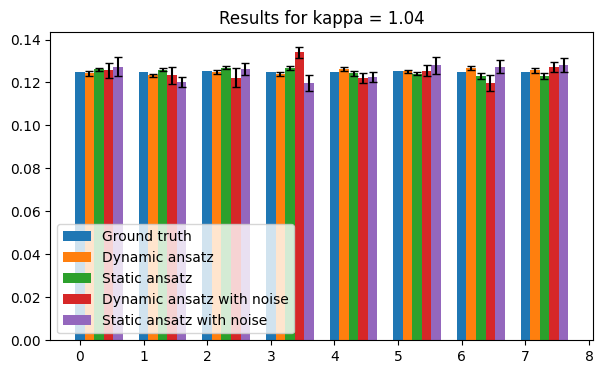

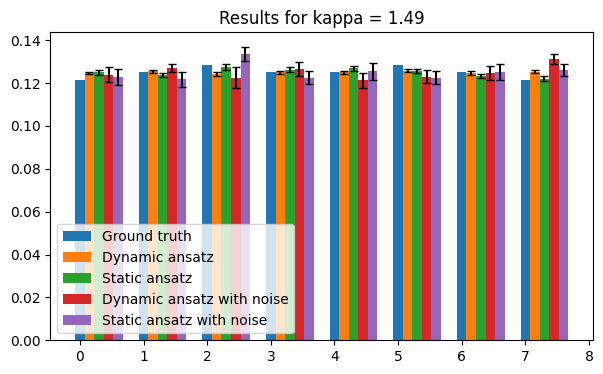

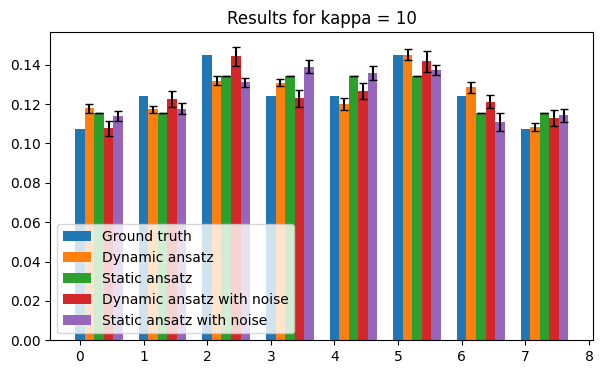

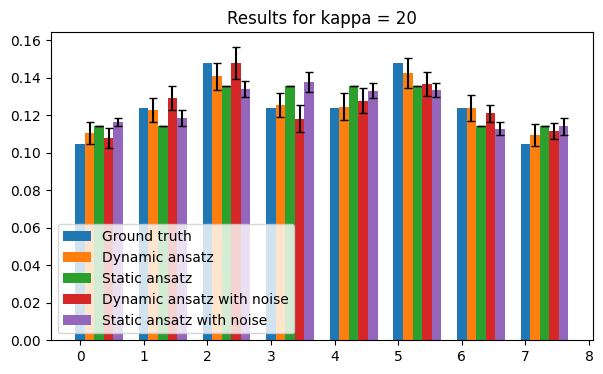

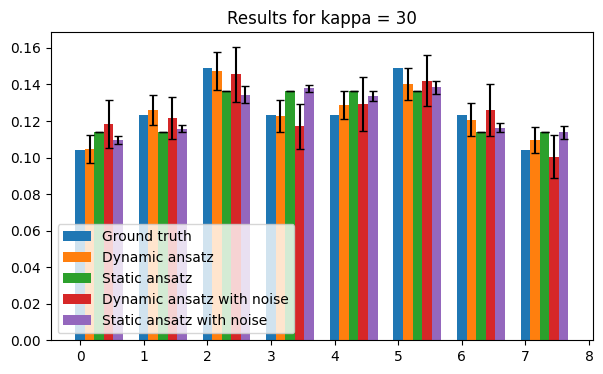

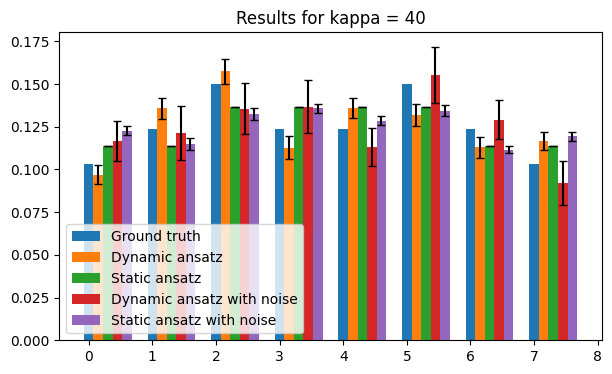

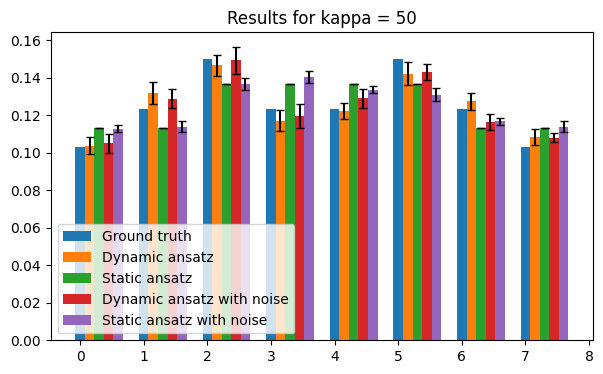

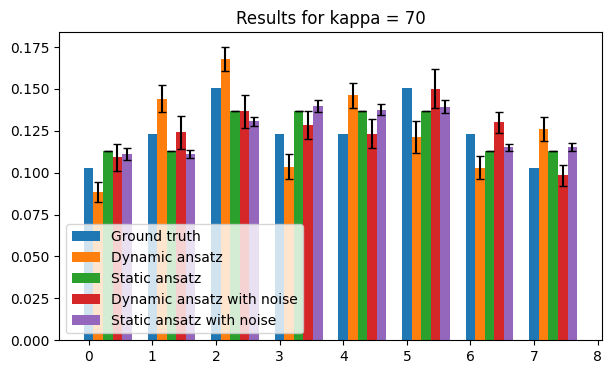

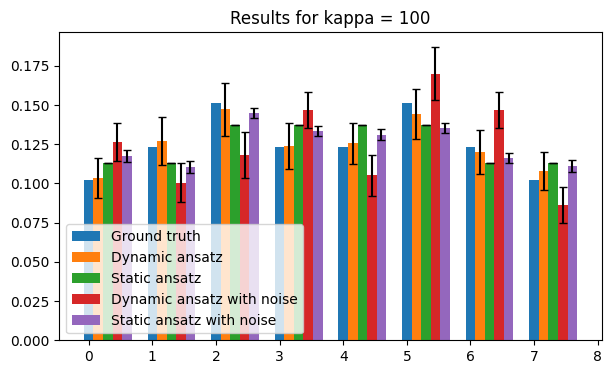

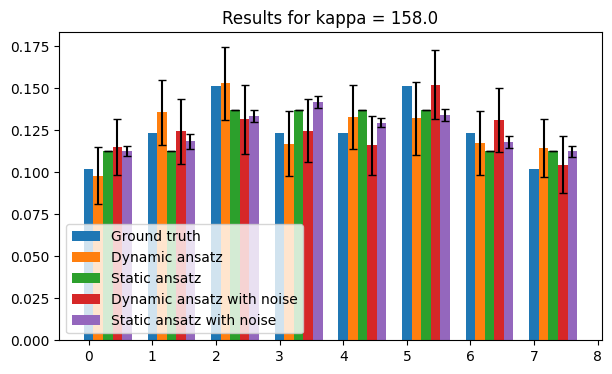

In [48]:

error_list = np.zeros([len(kappa_list), 4])


for i, KAPPA in enumerate(kappa_list):

    plt.figure(figsize=(7, 4))
    plt.title(f"Results for kappa = {KAPPA}")

    x = np.arange(len(classical_solution[i, :])) 
    width = 0.15 
    multiplier = 0
    
    plt.bar(x, classical_solution[i, :], width = width, label='Ground truth')
    plt.bar(x + width,  mean_results_dynamic[i, :], yerr=std_results_dynamic[i, :], width=width, capsize=3, label='Dynamic ansatz')
    plt.bar(x + 2*width, mean_results_static[i, :], yerr=std_results_static[i, :], width=width, capsize=3, label='Static ansatz')
    plt.bar(x + 3*width, mean_results_dynamic_noise[i, :], yerr=std_results_dynamic_noise[i, :], width=width, capsize=3, label='Dynamic ansatz with noise')
    plt.bar(x + 4*width, mean_results_static_noise[i, :], yerr=std_results_static_noise[i, :], width=width, capsize=3, label='Static ansatz with noise')
    
    error_dynamic = np.linalg.norm(mean_results_dynamic[i, :] - np.abs(classical_solution[i, :])) / np.linalg.norm(classical_solution[i, :])
    error_static = np.linalg.norm(mean_results_static[i, :] - np.abs(classical_solution[i, :])) / np.linalg.norm(classical_solution[i, :])
    error_dynamic_noise = np.linalg.norm(mean_results_dynamic_noise[i, :] - np.abs(classical_solution[i, :])) / np.linalg.norm(classical_solution[i, :])
    error_static_noise = np.linalg.norm(mean_results_static_noise[i, :] - np.abs(classical_solution[i, :])) / np.linalg.norm(classical_solution[i, :])
    
    error_list[i, 0] = error_dynamic
    error_list[i, 1] = error_static
    error_list[i, 2] = error_dynamic_noise
    error_list[i, 3] = error_static_noise



    plt.legend()
    plt.show()

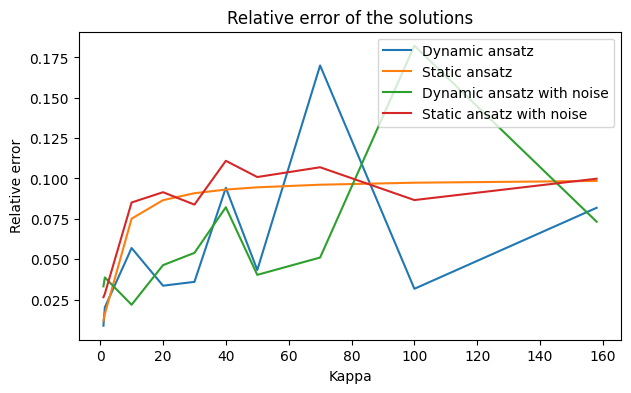

In [49]:
plt.figure(figsize=(7, 4))
plt.plot(kappa_list, error_list[:, 0], label='Dynamic ansatz')
plt.plot(kappa_list, error_list[:, 1], label='Static ansatz')
plt.plot(kappa_list, error_list[:, 2], label='Dynamic ansatz with noise')
plt.plot(kappa_list, error_list[:, 3], label='Static ansatz with noise')
plt.xlabel('Kappa')
plt.ylabel('Relative error')
plt.title('Relative error of the solutions')
plt.legend()
plt.show()

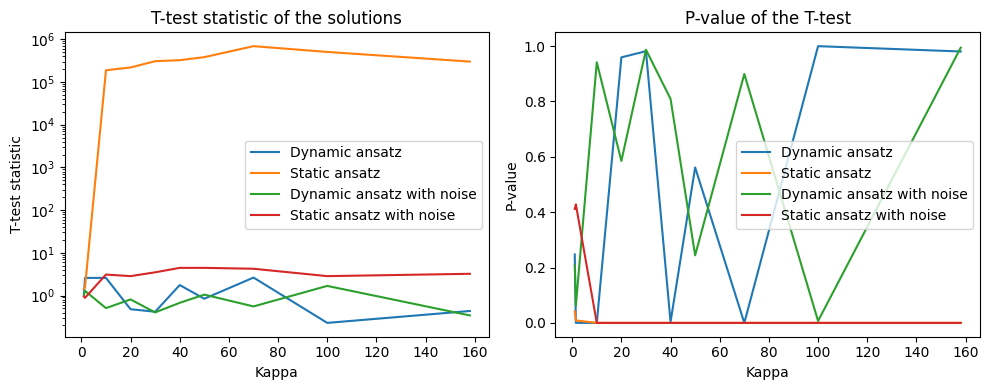

In [54]:
#Make 2 subplots one for ttest and one for p values

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(kappa_list, ttest_list_dynamic_stat.mean(axis=1), label='Dynamic ansatz')
plt.plot(kappa_list, ttest_list_static_stat.mean(axis=1), label='Static ansatz')
plt.plot(kappa_list, ttest_list_dynamic_noise_stat.mean(axis=1), label='Dynamic ansatz with noise')
plt.plot(kappa_list, ttest_list_static_noise_stat.mean(axis=1), label='Static ansatz with noise')
plt.xlabel('Kappa')
plt.ylabel('T-test statistic')
plt.yscale('log')
plt.title('T-test statistic of the solutions')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(kappa_list, ttest_list_dynamic_p, label='Dynamic ansatz')
plt.plot(kappa_list, ttest_list_static_p, label='Static ansatz')
plt.plot(kappa_list, ttest_list_dynamic_noise_p, label='Dynamic ansatz with noise')
plt.plot(kappa_list, ttest_list_static_noise_p, label='Static ansatz with noise')
plt.xlabel('Kappa')
plt.ylabel('P-value')
plt.title('P-value of the T-test')
plt.legend()
plt.tight_layout()
plt.show()

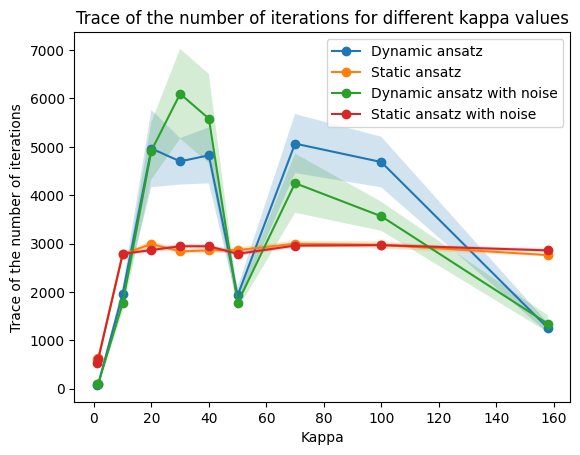

In [21]:
plt.plot(kappa_list, mean_trc_dynamic, label='Dynamic ansatz', marker='o')
plt.fill_between(kappa_list, mean_trc_dynamic - std_trc_dynamic, mean_trc_dynamic + std_trc_dynamic, alpha=0.2)
plt.plot(kappa_list, mean_trc_static, label='Static ansatz', marker='o')
plt.fill_between(kappa_list, mean_trc_static - std_trc_static, mean_trc_static + std_trc_static, alpha=0.2)
plt.plot(kappa_list, mean_trc_dynamic_noise, label='Dynamic ansatz with noise', marker='o')
plt.fill_between(kappa_list, mean_trc_dynamic_noise - std_trc_dynamic_noise, mean_trc_dynamic_noise + std_trc_dynamic_noise, alpha=0.2)
plt.plot(kappa_list, mean_trc_static_noise, label='Static ansatz with noise', marker='o')
plt.fill_between(kappa_list, mean_trc_static_noise - std_trc_static_noise, mean_trc_static_noise + std_trc_static_noise, alpha=0.2)
plt.xlabel('Kappa')
plt.ylabel('Trace of the number of iterations')

plt.title('Trace of the number of iterations for different kappa values')
plt.legend()
plt.show()